# AEM simulation over SWI grid

In [9]:
from IPython.display import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
import scipy.stats as sts
import flopy
import SGD
from local_utils import *
#Imports from simpegEM1D notebook Test_global_em1d_inversion_td-Copy2
from SimPEG import Mesh, Maps, Utils, EM
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, 
    EM1DSurveyTD,skytem_HM_2015
)
from pymatsolver import PardisoSolver

#Imports from simpegskytem notebook SLO-simulation
sys.path.append('../../kang-2019-3D-aem/kang-2019-3D-aem/codes')
from scipy.constants import mu_0
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey
import pandas as pd
from scipy.interpolate import NearestNDInterpolator


#Name model


modelname = 'homogenous'
if sys.platform == "darwin":
    model_ws = Path('../work').joinpath(modelname)
elif sys.platform == "win32":
    model_ws = Path(r'E:\Projects\DelawareSGD\work').joinpath(modelname)
#     model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe #set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))


workdir = Path('../')
figdir=  workdir.joinpath('work','figs')
datadir = workdir.joinpath('data')
objdir =  workdir.joinpath('data','objs')

if not figdir.exists():
    figdir.mkdir()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model workspace: /Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/homogenous


### 1) Rock-physics
#### Model: Use W-S to calculate end members (Clay,Sand) and Hashin-Strickman upper bound to upscale





### W-S
$\large \sigma_b = \frac{1}{F} (\sigma_{f} + B*Q_{v})$
$F$ = Formation factor = $\phi^{-m}$
<br>
$\phi$ = Porosity
<br>
$m$ = Cementation exponent
<br>
$\sigma_f$ = Fluid conductivity
<br>
$B$ = 
<br>
$Q_v$ = 
<br><br>

### HS+

<img src="HSU.png" alt="Drawing" style="width: 300px;" align="Left"/>
<br><br><br><br>


$\chi$ = Volume fraction 
<br>
$\sigma$ = Conductivity
<br>


In [10]:
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
m.MC_file = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/homogenous/MC_expt_2020-01-30-14-40/expt.txt')


In [11]:
import simulationFFT
#model size
nlay,nrow,ncol = (26, 20, 100)
delv,delc,delr = (3., 30., 30.)
varlist = load_obj(m.MC_file.parent,'varlist_final')


it = 1
CF_glob = varlist['CF_glob'][it]
CF_var = varlist['CF_var'][it]
corr_len = varlist['corr_len'][it]
corr_len_yx = varlist['corr_len_yx'][it]
corr_len_zx = varlist['corr_len_zx'][it]
vario_type = varlist['vario_type'][it]
lcol = int(corr_len/delr)
llay = int(corr_len*corr_len_zx/np.mean(delv))
lrow = int(corr_len*corr_len_yx/delc)
seed = varlist['seed'][it]

cf_mat = simulationFFT.simulFFT(nrow,nlay, ncol,
                                 CF_glob,
                                 CF_var,
                                 vario_type,
                                 lrow , llay, lcol,seed=seed)

cf_mat[cf_mat > 1.] = 1.
cf_mat[cf_mat < 0.] = 0.


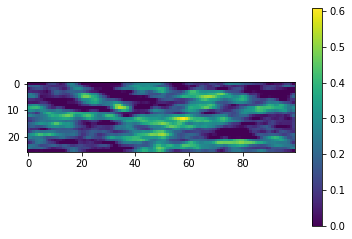

In [12]:
plt.imshow(cf_mat[:,0,:])
plt.colorbar()

In [15]:
import hausdorff_from_dir

def linear_RP(conc_mat,F=5.8,mTDS=1.4200556641030946,bTDS=332.7093594248108):
    Cw = (mTDS*conc_mat*1000 + bTDS)/1e4
    return F/Cw


def WS_sigma(sigma_f, por = 0.4, CEC=1,B0=4.5e-8, m=1.3):
    rho_grain = 2650*1000 #g/m^3
#     CEC = 1 #meq/g    1:smect,  .2:Ill,  .02-.09:Kaol
#     B0 = 4.78e-8  #m^2/(sV)
    F = por**(-m)
    Qv = rho_grain*((1-por)/por)*CEC
    B = B0*(1-.6*np.exp(-sigma_f/.013))
    sigma_b = 1/F*(sigma_f + B*Qv)
    return sigma_b,B,Qv


def HSU(conc_mat,CF_mat,mTDS=1.4200556641030946,bTDS=332.7093594248108,**kwargs):
    #kwargs fed to WS_sigma
    Cw = (mTDS*conc_mat*1000 + bTDS)/1e4
    sig_bs = WS_sigma(Cw,CEC=0,**kwargs)[0]
    sig_bc = WS_sigma(Cw,CEC=1,**kwargs)[0]
    return sig_bc*(1 - (3*(1-CF_mat)*(sig_bc-sig_bs))/(3*sig_bc - CF_mat*(sig_bc-sig_bs)))


#Make .npy files of concentration
import flopy 
ucnobj = flopy.utils.binaryfile.UcnFile(m.MC_file.parent.joinpath(
    'conc1_20200130_1445_totim14400.UCN').as_posix())
totims = ucnobj.get_times()[2::20]
fnames = hausdorff_from_dir.create_concmat_from_ucndir(m.MC_file.parent,totims=totims)
name1 = fnames[0]
name2 = fnames[3]

conc_mat1 = np.load(m.MC_file.parent.joinpath(name1))
conc_mat2 = np.load(m.MC_file.parent.joinpath(name2))

file 0 of 1
Removing 0 files out of 1...
it 0
i 0
saving...
...done!


#### Plot an example of workflow

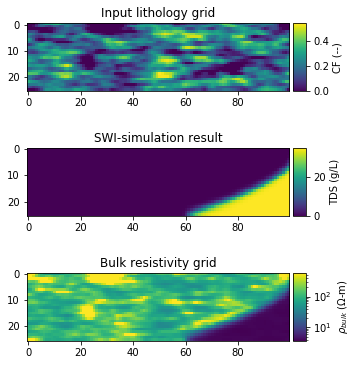

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

rowslice = 5
cmat = conc_mat1[0]
# cf_mat = np.random.rand(cmat.shape[0],cmat.shape[1],cmat.shape[2])
sig_mat = HSU(cmat,cf_mat,por=.1)

f,axs=  plt.subplots(3,1,figsize=(5,6.5))

plt.sca(axs.flatten()[0]) 
ax=plt.gca()
grid = plt.imshow(cf_mat[:,rowslice,:])
plt.title('Input lithology grid')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_label( 'CF (--)')


plt.sca(axs.flatten()[1]) 
ax=plt.gca()
grid =plt.imshow(cmat[:,rowslice,:])
plt.title('SWI-simulation result')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_label( 'TDS (g/L)')

plt.sca(axs.flatten()[2]) 
ax=plt.gca()
grid = plt.imshow(1/sig_mat[:,rowslice,:],cmap='viridis',norm=LogNorm())
plt.title('Bulk resistivity grid')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_ticks((10,100))
cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')

plt.savefig(figdir.joinpath('RP_workflow_time1.png'),bbox_inches='tight',dpi=300)

### Adding in AEM simulations

In [27]:
conc_mat.shape

(1, 26, 20, 100)

In [29]:
conc_mat =np.concatenate((conc_mat1,conc_mat2),axis=0)

In [31]:
%matplotlib inline

nlay,nrow,ncol = (conc_mat[0].shape)
dx,dy,dz = (30,30,3)
Lx,Ly,Lz = (dx*ncol,dy*nrow,dz*nlay)
#Mesh
n_pad_ocean = 300
n_pad_inland = 300
n_pad_row = 300

n_sounding_x = ncol
n_sounding_y = nrow
hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(nrow + 2*n_pad_row) * dy

# hz = np.ones(nlay) * delv
# hz = np.diff(np.r_[0.,henry_botm])

dept_low = np.arange(-75,dz,dz)
dept_air = np.arange(dz,50,dz)
dept = np.r_[dept_low,dept_air]
hz = dz*np.ones_like(dept)
x0 = (-n_pad_inland*dx,-n_pad_row*dy,-76)
mesh = Mesh.TensorMesh([hx, hy, hz],x0=x0)

###Padding
#Change from (lay,row,col) to (col,row,lay)
rho_transf = 1/HSU(cmat,conc_mat[1],por=.3)
#Air padding
rho_transf = np.append(rho_transf,np.ones((16,rho_transf.shape[1],rho_transf.shape[2])),axis=0)

#Row padding
rho_transf = np.append(rho_transf,
                       np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                       axis=1)
rho_transf = np.append(np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                       rho_transf,
                       axis=1)

#Ocean padding
rho_transf = np.append(rho_transf,
                           0.2*np.ones((rho_transf.shape[0],rho_transf.shape[1],n_pad_ocean)),axis=2)



#Inland padding
rho_transf = np.append(rho_transf[:,:,0].max()*np.ones(
                           (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),
                       rho_transf,
                       axis=2)





z_air_inds = np.argwhere(mesh.vectorCCz >0)
rho_transf[z_air_inds,:,:]=100

actv_col_row_lay = np.ones_like(rho_transf,dtype=bool)
actv_col_row_lay[z_air_inds,:,:]=False
actv_col_row_lay = np.transpose(actv_col_row_lay,(2,1,0)) 
actv = actv_col_row_lay.flatten(order='F')


rho_col_row_lay = np.transpose(rho_transf,(2,1,0)) 
rho =  rho_col_row_lay.flatten(order='F')

# actv = np.ones_like(rho,dtype=bool)
# actv_air = actv_col_row_lay_air.flatten()


# mesh.plot_3d_slicer(rho,pcolorOpts={"norm":LogNorm()})



# cb = plt.colorbar(ax=plt.gca())
# cb.set_label(r'$\rho$  $(\Omega-m)$')
# plt.suptitle('2D slice of mesh',fontsize=14)

In [53]:
#Set source and receiver locations
pad_amt = 0
xmin, xmax = pad_amt, Lx-pad_amt
ymin, ymax = pad_amt, Ly-pad_amt

# generate survey
x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
y_inds = np.argwhere(np.logical_and(mesh.vectorCCy > ymin, mesh.vectorCCy < ymax))
x = mesh.vectorCCx[x_inds[::4]]
y = mesh.vectorCCy[y_inds[::4]]
# f_dem = NearestNDInterpolator(dem[:,:2], dem[:,2])
xy = Utils.ndgrid(x, y)
# z = f_dem(xy)

#Source and receiver height
z = np.zeros(len(xy))
src_height = 30.
src_locations = np.c_[xy, z + src_height]
rx_locations = np.c_[xy[:,0]+13.25, xy[:,1], z+2.+ src_height]
topo = np.c_[xy, z]
n_sounding = src_locations.shape[0]
print(n_sounding)

125


In [74]:
x_AEMgreaterThan1000 = np.argwhere(xy[:,0]>1000)
np.save(Path(aemdir).joinpath('x_AEMgreaterThan1000'),x_AEMgreaterThan1000)

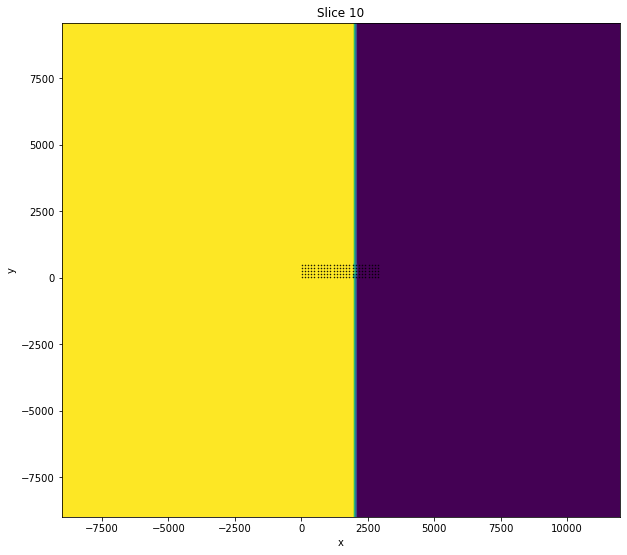

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
mesh.plotSlice(rho_col_row_lay, clim=(10, 40), ind=10, ax=ax)
ax.plot(src_locations[:,0], src_locations[:,1], 'k.', ms=1)
ax.set_aspect(1)

In [55]:
#Waveform 

#Get LM and HM from simpegskytem
import simpegskytem
from simpegskytem import Utils

simpegskytem_path = Path(simpegskytem.__file__).parent.parent.parent
print('simpegskytem path:\t',simpegskytem_path)

unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/waveform_hm_312.txt'))
waveform_lm_312 = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/waveform_lm_312.txt'))
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/time_gates'))
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312


GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

simpegskytem path:	 /Users/ianpg/Documents/ProjectsLocal/SWIsmall


In [56]:
times_lm_312

array([1.09700e-05, 1.79800e-05, 2.69700e-05, 3.84700e-05, 5.29700e-05,
       7.09700e-05, 9.34600e-05, 1.21460e-04, 1.56960e-04, 2.02460e-04,
       2.59460e-04, 3.31460e-04, 4.22460e-04, 5.36460e-04, 6.80460e-04,
       8.61960e-04, 1.09076e-03, 1.37876e-03])

In [57]:
#Make survey and problem (simulation)
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_hm_312,
    time_input_currents_hm_312,
    input_currents_hm_312,
    base_frequency=25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_lm_312,
    time_input_currents_dual_moment=time_input_currents_lm_312,
    input_currents_dual_moment=input_currents_lm_312,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

simulation_workdir = m.MC_file.parent.joinpath('tmp')
try:
    simulation_workdir.mkdir()
except:
    pass

simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho, 
    actv=actv, 
    parallel_option='multiprocess',
    n_cpu=4,
    work_dir=simulation_workdir.as_posix()
)

simulation.pair(survey)

>> Set parameters


In [58]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_hm_312,
    time_input_currents_hm_312,
    input_currents_hm_312,
    base_frequency=25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_lm_312,
    time_input_currents_dual_moment=time_input_currents_lm_312,
    input_currents_dual_moment=input_currents_lm_312,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

>> Set parameters


In [40]:
%time simulation.write_inputs_on_disk_pool()

Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/Users/ianpg/anaconda/en

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/queues.py", line 340, in get
    return _ForkingPickler.loads(res)
Process ForkPoolWorker-1:
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/dill/_dill.py", line 317, in loads
    return load(file, ignore)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/dill/_dill.py", line 305, in load
    obj = pik.load()
_pickle.UnpicklingError: invalid load key, '\x00'.
Traceback (most recent call last):
  File "/Users/ianpg

In [88]:
%time data = simulation.forward(1./rho)

Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", lin

KeyboardInterrupt: 

Process ForkPoolWorker-10:
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "../../kang-2019-3D-aem/kang-2019-3D-aem/codes/simpegskytem/EMSimulation.py", line 112, in run_simulation_skytem
    base_frequency_dual_moment=base_frequency_dual_moment
  File "../../kang-2019-3D-aem/kang-2019-3D-aem/codes/simpegskytem/TDEM.py", line 89, in simulate
    sol_n2 = Ainv*rhs
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python

In [59]:
aemdir = '/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/heterog_1000/MC_expt_2020-02-01-18-15/export_1000/aem_data_1000'
data = load_obj(aemdir,'aem_data_it491')[0]
n_sounding = 125

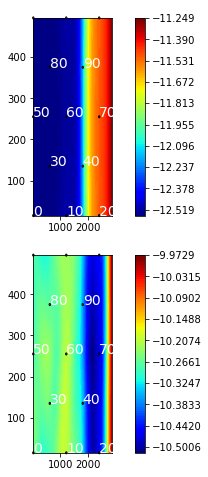

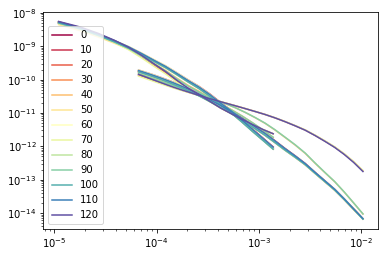

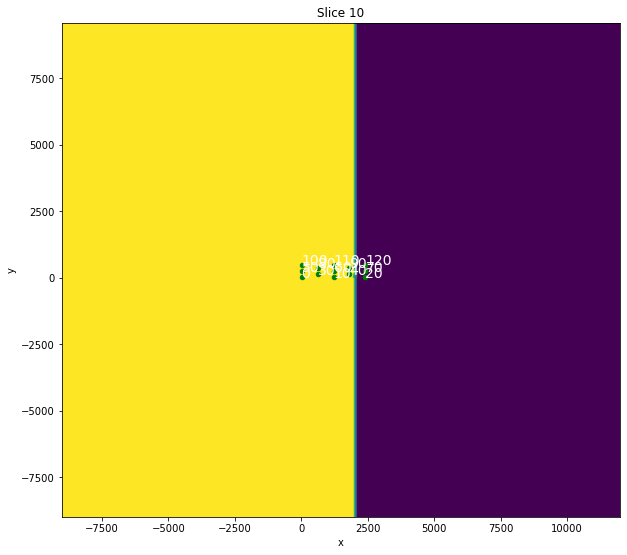

In [61]:
DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
DATA_HM = -DATA[:times_hm_312.size,:]
DATA_LM = -DATA[times_hm_312.size:,:]

def circle(x, y, w,h):
    from matplotlib.patches import Circle,Ellipse
    from matplotlib.patheffects import withStroke
    circle = Ellipse((x, y), w,h, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125))
#                     path_effects=[withStroke(linewidth=5, foreground='w')])
    ax.add_artist(circle)


# i_sounding = (0,26,54,83)
i_sounding = np.arange(0,125,10)
   
    
f,axs = plt.subplots(2,1,figsize=(8,8))

i_time = 20
plt.sca(axs.flatten()[0])
ax = plt.gca()
grid =Utils.plot2Ddata(xy,np.log10(DATA_HM[i_time,:]), ncontour=100, contourOpts={'cmap':'jet'},ax=ax )
plt.colorbar(grid[0])

for i in i_sounding:
    circle(xy[i,0],xy[i,1],50,5)
    plt.annotate(str(i),(xy[i,0],xy[i,1]),color='w',fontsize=14)


ax.set_aspect(15)

i_time = 10
plt.sca(axs.flatten()[1])
ax = plt.gca()
grid = Utils.plot2Ddata(xy, np.log10(DATA_LM[i_time,:]), ncontour=100, contourOpts={'cmap':'jet'},ax=ax)
plt.colorbar(grid[0])
for i in i_sounding:
    circle(xy[i,0],xy[i,1],50,5)
    plt.annotate('{}'.format(i),(xy[i,0],xy[i,1]),color='w',fontsize=14)

ax.set_aspect(15)

plt.figure()
cmap = matplotlib.cm.get_cmap('Spectral')
for i in i_sounding:
    plt.loglog(times_hm_312, DATA_HM[:,i],color = cmap(i/max(i_sounding)),label=i)
    plt.loglog(times_lm_312, DATA_LM[:,i],color = cmap(i/max(i_sounding)))
plt.legend()



fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
mesh.plotSlice(rho, clim=(10, 40), ind=10, ax=ax)
for i in i_sounding:
    ax.scatter(src_locations[i,0], src_locations[i,1], s=20,c='green')
    plt.annotate('{}'.format(i),(xy[i,0],xy[i,1]),color='w',fontsize=14)
ax.set_aspect(1)

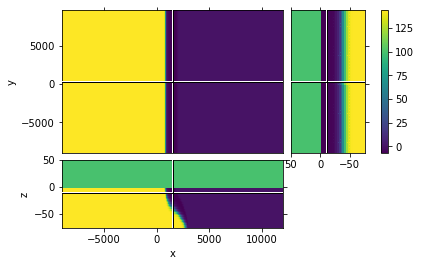

In [63]:
mesh.plot_3d_slicer(rho)

In [45]:
5625/(times_hm_312.size+times_lm_312.size)

125.0

In [234]:
matplotlib.cm.get_cmap('Spectral')

TypeError: from_list() missing 2 required positional arguments: 'name' and 'colors'

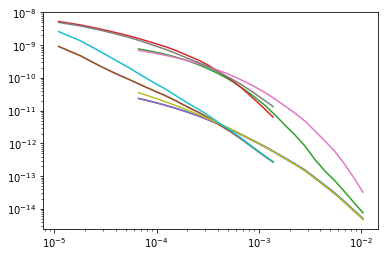

### Additional changes and considerations
#### To do:

-Change to continuous gaussian sim for HK


____________________________

#### Considerations:

-Fix HK and instead change the HK_variance? To minimize effects of HK

-Run to steady state or fixed amount of time?

-Transient simulations: frequency of snapshots?

-Initial concentration: FW-saturated? Fine if fixed time sims; otherwise partially SW intruded?


### Joint inversion paper
How likely are we to see improvements to SW intruded aquifer from a time-lapse AEM study?

0) Simulation of SWI + remediation --> simulate AEM

1) Comparison of 2 datasets 2017, 2019

2) Joint inversion of 2 datasets 2017, 2019